Date: 27/10/2019

Environment: Python 3.7.3 and Anaconda 1.9.7 (64-bit)

Libraries used:
* pandas 0.24.2 (for data frame, included in Anaconda Python)
* numpy 1.16.4 (To convert time and datalist to array)
* matplotlib 3.1.0 (Matplotlib is a Python 2D plotting library used for boxplots, included in Anaconda Python)
* shapefile 2.1.0 (The Python Shapefile Library (PyShp) reads and writes ESRI Shapefiles in pure Python)
* math (It provides access to the mathematical functions defined by the C standard, included in Anaconda Python)
* shapely 1.6.4.post1 (Manipulation and analysis of geometric objects in the Cartesian plane.)
* sklearn 0.21.2 (Simple and efficient tools for data mining and data analysis used for KNN and LinearRegression, included in Anaconda Python)
* beautifulsoup4 4.8.0 (To parse HTML files)
* urllib3 1.24.2 (To access the web page links)
* re 2.2.1 (to match/search/find patterns)



## 1. Introduction
This assignment requires us to integrate several datasets into one single schema and find and fix possible problems in the data. The final schema should include below fields from other files:

1) Suburb : The property suburb. The suburb must only be calculated using Vic_suburb_boundary.zip. Default value: "not available"

2) train_station_id : The closest train station to the property that has a direct trip to the Southern Cross Railway Station. A direct trip is a trip where there are no connections (transfers) in the trip from the origin to the destination. Default value: -1.

3) distance_to_train_station : The direct distance from the closest train station to the property that has a direct trip to the Southern Cross Railway Station. Default value: -1.

4) travel_min_to_CBD : The average travel time (minutes) from the closest train station (regional/metropolitan) that has a direct trip to the “Southern Cross Railway Station” on weekdays (i.e. Monday-Friday) departing between 7 to 9:30 am. For example, if there are 3 direct trips departing from the closest train station to the Southern Cross Railway Station on weekdays between 7-9:30 am and each takes 6, 7, and 8 minutes respectively, then the value of this column for the property should be (6+7+8)/3.). Default value: -1.

5) over_priced? : A boolean feature indicating whether or not the price of the property is higher than the median price of similar properties (with respect to bedrooms, bathrooms, parking_space, and property_type attributes) in the same suburb on the year of selling. Default value: -1.

6) crime_A_average : The average of type A crime in the local government area the property belongs to, in the three years prior to selling the property as the property. For example, if a property is sold in 2016, then you should calculate the average of the crime type A for 2013, 2014 and 2015. Default value: -1.

7) crime_B_average : The average of type B crime in the local government area the property belongs to, in the three years prior to selling the property as the property. For example, if a property is sold in 2016, then you should calculate the average of the crime type B for 2013, 2014 and 2015. Default value: -1.

8) crime_C_average : The average of type C crime in the local government area the property belongs to, in the three years prior to selling the property as the property. For example, if a property is sold in 2016, then you should calculate the average of the crime type C for 2013, 2014 and 2015. Default value: -1.

9) closest_primary_school : The name of the closest primary school to the property. Default value: "not available".

10) distance_to_closest_primary : The direct distance between the property and the closest primary school. Default value: -1.

11) primary_school_ranking : The ranking of the closest primary school to the property as scraped from http://www.schoolcatchment.com.au/?p=12301 If the school is not listed, the value of this field should be set to “not ranked”. Default value: -1.

12) closest_secondary_school : The name of the closest secondary school to the property. Default value: "not available".

13) distance_to_closestsecondary : The direct distance between the property and the closest secondary school. Default value: -1.

14) secondary_school_ranking : The ranking of the closest secondary school to the property as scraped from https://sites.google.com/a/monash.edu/secondary-school-ranking/ If the school is not listed, the value of this field should be set to “not ranked”. Default value: -1.


More details for each task will be given in the following sections.

### 1.1 Importing required libraries

In [1]:
# To work with dataframes 
import pandas as pd

# To access shape files
import shapefile

# To consider data in form of point (x,y)/vertex
from shapely.geometry import Point

# To construct a polygon using sequence of vertices
from shapely.geometry.polygon import Polygon

# To calculate distance
import math
from math import sin, cos, sqrt, atan2, radians, isnan, sqrt, pow, log

# To calculate travel time in minutes
import numpy as np

# To plot graphs
from matplotlib import pyplot as plt
%matplotlib inline

# To create regression models and calculate accuracy
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# To read data from html files/webpage
import xml.etree.ElementTree as et
from urllib.request import urlopen
from bs4 import BeautifulSoup

# To search/match/find patterns
import re

# 2. Task 1 : Data Integration

### 2.1. Loading the data

In [2]:
data = pd.read_csv("Group010.csv")

In [3]:
data.describe()

,Rooms,Price,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
count,720.000000,7.200000e+02,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,2.912500,1.062501e+06,1.538889,1.593056,587.227778,51.298611,-37.804646,144.995778
std,0.959172,6.340100e+05,0.698609,0.990754,1244.105746,35.240852,0.078448,0.100231
min,1.000000,1.850000e+05,0.000000,0.000000,0.000000,2.000000,-38.164920,144.572610
25%,2.000000,6.587500e+05,1.000000,1.000000,171.500000,19.000000,-37.851175,144.931925
50%,3.000000,8.900000e+05,1.000000,2.000000,465.000000,49.000000,-37.796480,144.999210
75%,3.000000,1.281250e+06,2.000000,2.000000,662.000000,69.000000,-37.751030,145.054903
max,7.000000,6.500000e+06,6.000000,7.000000,21715.000000,163.000000,-37.575650,145.348030


In [4]:
# Printing the dimension of the original dataframe
print('Dimension of the original dataframe : ', data.shape)

# Let's drop duplicates and make sure there are unique rows in our dataframe
print('Dimension of the dataframe after dropping duplicates : ', data.drop_duplicates().shape)

Dimension of the original dataframe :  (720, 12)
Dimension of the dataframe after dropping duplicates :  (682, 12)


As we can see that there are 38 duplicate records, we drop those columns and reconsider our dataset.

In [5]:
# Dropping the duplicates 
data = data.drop_duplicates().reset_index()

# Since we reset the index, a new column index was formed, we need to remove that column
data = data.drop(columns=['index'])

# Displaying the head of the dataframe
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID132998300,101 Charles St,2,h,911000.0,22/07/2017,1.0,0.0,141.0,139.0,-37.80586,144.99499
1,ID869487055,294 Moray St,2,h,1355000.0,3/12/2016,1.0,0.0,101.0,107.0,-37.83590,144.96440
2,ID144266393,3/32 Wimba Av,2,u,860000.0,12/08/2017,2.0,1.0,0.0,69.0,-37.80593,145.05121
3,ID575297401,32 Murray St,2,h,949500.0,13/05/2017,1.0,1.0,689.0,59.0,-37.70520,144.96400
4,ID450688441,2/12 Moorong St,4,t,1042500.0,11/02/2017,3.0,2.0,209.0,3.0,-37.88050,145.10500


### 2.2. Checking ID column

This column represents unique ID for the property. We check this by displaying the length of the unique elements in `ID` column. If we the value we get matches with total number of records, 682, then it implies that all the IDs are unique.

In [6]:
print('Number of unique IDs : ',len(data['ID'].unique()))

Number of unique IDs :  682


As we got 682 unique IDs, we can conclude that the `ID` column is unique.

### 2.3. Finding the Suburb

This column represents the property suburb. The suburb is calculated using Vic_suburb_boundary.zip. It's default value is `not available`. We have to find out the suburb based on `Shapefiles` that encode points, lines, curves, and polygons. This is useful for mapping applications where you need to represent county lines, major highways, lakes, etc. 

In [7]:
# Read the shape files 
sf = shapefile.Reader("vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp")

# To fetch the records
recs = sf.records()

# To fetch the list of the shapefiles geometry
shapes = sf.shapes()

In [8]:
# Display the dataframe
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID132998300,101 Charles St,2,h,911000.0,22/07/2017,1.0,0.0,141.0,139.0,-37.80586,144.99499
1,ID869487055,294 Moray St,2,h,1355000.0,3/12/2016,1.0,0.0,101.0,107.0,-37.83590,144.96440
2,ID144266393,3/32 Wimba Av,2,u,860000.0,12/08/2017,2.0,1.0,0.0,69.0,-37.80593,145.05121
3,ID575297401,32 Murray St,2,h,949500.0,13/05/2017,1.0,1.0,689.0,59.0,-37.70520,144.96400
4,ID450688441,2/12 Moorong St,4,t,1042500.0,11/02/2017,3.0,2.0,209.0,3.0,-37.88050,145.10500


In [9]:
def findSuburb(pt):
    # Iterate through the length of shapes
    for i in range(0,len(shapes)):
        
        # Initialize a shapefile entry
        boundary = shapes[i]
        
        # Create a polygon based on points
        polygon = Polygon(boundary.points)
        
        # Convert longitude and lattitude into point/vertex form
        point = Point(pt)
        
        # Check if the polygon contains point
        if polygon.contains(point):
            # Return the suburb from the record
            return recs[i][6]
    
    # Reurn default value if not polygon doesn't contains the point
    return 'not available'

In [10]:
# Iterate through the data dataframe 
for index, row in data.iterrows():
    # Initialize a point
    point = row['Longtitude'],row['Lattitude']
    
    # Finding the suburb based on the longitude and lattitude values
    suburb = findSuburb(point)
    
    # Assign the corresponding suburb value to that index
    data.loc[index,'Suburb'] = suburb

The logic in the above two cells boils down to checking if the lat/lon present in the housing dataset are present in the shapes file. If yes, return suburb or else return default value.

In [11]:
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb
0,ID132998300,101 Charles St,2,h,911000.0,22/07/2017,1.0,0.0,141.0,139.0,-37.80586,144.99499,ABBOTSFORD
1,ID869487055,294 Moray St,2,h,1355000.0,3/12/2016,1.0,0.0,101.0,107.0,-37.83590,144.96440,SOUTH MELBOURNE
2,ID144266393,3/32 Wimba Av,2,u,860000.0,12/08/2017,2.0,1.0,0.0,69.0,-37.80593,145.05121,KEW
3,ID575297401,32 Murray St,2,h,949500.0,13/05/2017,1.0,1.0,689.0,59.0,-37.70520,144.96400,FAWKNER
4,ID450688441,2/12 Moorong St,4,t,1042500.0,11/02/2017,3.0,2.0,209.0,3.0,-37.88050,145.10500,CHADSTONE


In [12]:
data[data['Suburb'] == 'not available']

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb


From the above code result, we can see that there are no suburbs with default value 'not available'. This implies that our dataset didn't have location for which suburb was not available.


### 2.4. Calculating the train_station_id, distance_to_train_station and travel_min_to_CBD using GTFS dataset

Here, we need to find the details with respect to the regional/metropolitan areas which have direct trip to `Southern Cross Railway Station`. 

Based on our research about GTFS specification data, we checked `stop_name` column in `stops.txt` file for `Southern Cross Railway Station` and `route_long_name` column in `routes.txt` file to figure out if the route is regional/interstate. Based on the analysis, we figured out that relevant data is present under GTFS folders 1, 2 and 3. As a next step, we checked for the `route_type` in `routes.txt` file and noticed that only GTFS folders 1 and 2 contain the type as `2` where as folder 3 had type as `0`. On further analysis about the `route_type` column, we found out that type `2` represents rail which is used for intercity or long-distance travel and `0` represents tram, streetcar, light rail or any light rail or street level system within a metropolitan area. Hence we discard GTFS folder 3 and are left with folders 1 and 2.

To calculate the above fields, we would need information from the files below:
- `stop_times.txt` - Times that a vehicle arrives at and departs from stops for each trip.
- `stops.txt` - Stops where vehicles pick up or drop off riders. Also defines stations and station entrances.
- `calendar.txt` - Service dates specified using a weekly schedule with start and end dates.
- `trips.txt` - Trips for each route. A trip is a sequence of two or more stops that occur during a specific time period.

Now, we read the data from these folders into a dataframe.

In [13]:
# Initializing variables with path for files in folder 1 
tripsPath1 = 'gtfs/1/google_transit/trips.txt'
stopsPath1 = 'gtfs/1/google_transit/stops.txt'
stopTimesPath1 = 'gtfs/1/google_transit/stop_times.txt'
calendarPath1 = 'gtfs/1/google_transit/calendar.txt'

# Loading the required data frames
calendar = pd.read_csv(calendarPath1)
stopTimes = pd.read_csv(stopTimesPath1)
stops = pd.read_csv(stopsPath1)
trips = pd.read_csv(tripsPath1)

# Merge the data
merge2 = trips.merge(calendar, on="service_id")
merge3 = merge2.merge(stopTimes, on="trip_id")
mergedGTFS1 = merge3.merge(stops, on="stop_id")
print('Dimension of mergedGTFS1 dataframe: ', mergedGTFS1.shape)

Dimension of mergedGTFS1 dataframe:  (72489, 26)


In [14]:
# Initializing variables with path for files in folder 2
tripsPath2 = 'gtfs/2/google_transit/trips.txt'
stopsPath2 = 'gtfs/2/google_transit/stops.txt'
stopTimesPath2 = 'gtfs/2/google_transit/stop_times.txt'
calendarPath2 = 'gtfs/2/google_transit/calendar.txt'

# Loading the required data frames
calendar = pd.read_csv(calendarPath2)
stopTimes = pd.read_csv(stopTimesPath2)
stops = pd.read_csv(stopsPath2)
trips = pd.read_csv(tripsPath2)

# Merge the data
merge2 = trips.merge(calendar, on="service_id")
merge3 = merge2.merge(stopTimes, on="trip_id")
mergedGTFS2 = merge3.merge(stops, on="stop_id")
print('Dimension of mergedGTFS2 dataframe: ', mergedGTFS2.shape)

Dimension of mergedGTFS2 dataframe:  (469488, 26)


In [15]:
# Combine both the data frames now
mergedGTFS = mergedGTFS1.append(mergedGTFS2)
print('Dimension of mergedGTFS dataframe: ', mergedGTFS.shape)
mergedGTFS.head()

Dimension of mergedGTFS dataframe:  (541977, 26)


,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id,monday,tuesday,wednesday,thursday,...,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,stop_name,stop_lat,stop_lon
0,1-V08-G-mjp-1,T0,1051.T0.1-V08-G-mjp-1.1.H,1-V08-G-mjp-1.1.H,Melbourne,0,1,1,1,1,...,06:08:00,20291,1,NaN,0,0,0.000000,Bairnsdale Railway Station (Bairnsdale),-37.82872,147.627614
1,1-V08-G-mjp-1,T0,1052.T0.1-V08-G-mjp-1.2.H,1-V08-G-mjp-1.2.H,Melbourne,0,1,1,1,1,...,12:45:00,20291,1,NaN,0,0,0.000000,Bairnsdale Railway Station (Bairnsdale),-37.82872,147.627614
2,1-V08-G-mjp-1,T0,1053.T0.1-V08-G-mjp-1.2.H,1-V08-G-mjp-1.2.H,Melbourne,0,1,1,1,1,...,18:18:00,20291,1,NaN,0,0,0.000000,Bairnsdale Railway Station (Bairnsdale),-37.82872,147.627614
3,1-V08-G-mjp-1,T0,1522.T0.1-V08-G-mjp-1.4.R,1-V08-G-mjp-1.4.R,Bairnsdale,1,1,1,1,1,...,11:11:00,20291,23,NaN,0,0,276406.889886,Bairnsdale Railway Station (Bairnsdale),-37.82872,147.627614
4,1-V08-G-mjp-1,T0,1523.T0.1-V08-G-mjp-1.5.R,1-V08-G-mjp-1.5.R,Bairnsdale,1,1,1,1,1,...,17:07:00,20291,23,NaN,0,0,276406.889886,Bairnsdale Railway Station (Bairnsdale),-37.82872,147.627614


In the above cells, we have merged the required GTFS data from both folder1 and folder2.

We need only the trips that end at `South Cross Railway Station (SCR)`, run on weekdays only, run from 7-9:30 AM only and trips which are direct trip.

The logic that follows to achieve the above is that we filter out the trips which run only on weekends and between 7-9:30 AM. This is done via `weekdayMorningService` method which returns `0` or `1`. Next, we add a new column in mergedGTFS dataframe - `0` implies it is not a weekday morning service whereas `1` implies that it is a weekday morning service. After this, we apply filter on `stop_name` column for `Southern Cross Railway Station` and on `weekdayMorningService` column for `1`. Finally, we filter out the fields which have `stop_sequence` column value as `1` because value 1 implies that it is the first stop whereas we need the trips where  SCR is the destination stop. The resultant dataframe has data that is related to SCR weekday morning service.

Once we have SCR GTFS information, we iterate through each row in the housing dataset, get the distances from all the stops
in ascending order in a dataframe. Using this new dataframe, we look for a stop which has a direct trip to SCR. When we find that stop id, its corresponding distance is set as the distance to be calculated. This way, we calculate the station id and the distance. To calculate the average time, we make use of the stop id found in previous step - we look for all the trains and calculate the average time in minutes.

In [16]:
# Function used to create a flag for weekdays and time of train.
def weekdayMorningService(row):
    if row['monday'] == 1 and row['tuesday'] == 1 and row['wednesday'] == 1 and\
        row['thursday'] == 1 and row['friday'] == 1 and row['saturday'] == 0 and row['sunday'] == 0 and \
        row['departure_time'] >= "07:00:00" and row['departure_time'] <= "09:30:00":
        return 1
    else:
        return 0

In [17]:
# Use the above function to create the flag
mergedGTFS['weekdayMorningService'] = mergedGTFS.apply(lambda row: weekdayMorningService(row), axis=1)

In [18]:
# Finding stop ids of Southern Cross Railway Station
scStationIds = mergedGTFS[mergedGTFS['stop_name'].apply(lambda x : ('Southern Cross Railway Station') in x)]['stop_id'].unique().tolist()
print('Station IDs of Southern Cross Railway Station : ', scStationIds)

Station IDs of Southern Cross Railway Station :  [20043, 22180]


In [19]:
# Fetch data which has SCR as stop
scrData = mergedGTFS[mergedGTFS['stop_id'].isin(scStationIds)]

# Fetch data which has SCR as stop, service runs n weekdays and between 7-9:30 AM
scrData = scrData[scrData['weekdayMorningService'] == 1]

print('Dimension of scrData dataframe : ', scrData.shape)

Dimension of scrData dataframe :  (603, 27)


In [20]:
# Remove data from stop_sequence=1 because that would indicate the source as SC
scrData = scrData[scrData['stop_sequence'] != 1]
print('Dimension of scrData dataframe: ', scrData.shape)
scrData.head()

Dimension of scrData dataframe:  (502, 27)


,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id,monday,tuesday,wednesday,thursday,...,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,stop_name,stop_lat,stop_lon,weekdayMorningService
9451,1-V12-G-mjp-1,T0,1094.T0.1-V12-G-mjp-1.1.H,1-V12-G-mjp-1.1.H,Melbourne,0,1,1,1,1,...,20043,15,NaN,0,0,92030.094681,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525,1
9452,1-V12-G-mjp-1,T0,1080.T0.1-V12-G-mjp-1.2.H,1-V12-G-mjp-1.2.H,Melbourne,0,1,1,1,1,...,20043,19,NaN,0,0,162833.935955,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525,1
9457,1-V12-G-mjp-1,T0,1081.T0.1-V12-G-mjp-1.3.H,1-V12-G-mjp-1.3.H,Melbourne,0,1,1,1,1,...,20043,20,NaN,0,0,170688.669203,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525,1
9458,1-V12-G-mjp-1,T0,1082.T0.1-V12-G-mjp-1.4.H,1-V12-G-mjp-1.4.H,Melbourne,0,1,1,1,1,...,20043,21,NaN,0,0,182177.623411,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525,1
9459,1-V12-G-mjp-1,T0,1095.T0.1-V12-G-mjp-1.4.H,1-V12-G-mjp-1.4.H,Melbourne,0,1,1,1,1,...,20043,21,NaN,0,0,182177.623411,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525,1


In [21]:
# Set the initial values of the variables
data['train_station_id'] = -1
data['distance_to_train_station'] = -1
data['travel_min_to_CBD'] = -1

In [22]:
# Get the stop lists again
stops1 = pd.read_csv(stopsPath1)
stops2 = pd.read_csv(stopsPath2)
stops = stops1.append(stops2)
stops.head()

,stop_id,stop_name,stop_lat,stop_lon
0,17204,Wallan Railway Station (Wallan),-37.416861,145.005372
1,19980,Melton Railway Station (Melton South),-37.703293,144.572524
2,19981,Rockbank Railway Station (Rockbank),-37.729261,144.650631
3,19982,Deer Park Railway Station (Deer Park),-37.777764,144.772304
4,19998,Sunbury Railway Station (Sunbury),-37.579206,144.728165


In [23]:
def getDistance(originLat, originLon, destinationLat, destinationLon):
    
    # Initialising radius of earth (in meters)
    earthRadius = 6378000.0   

    # Converting the origin and destination lat lon into radians
    lat1 = radians(originLat)
    lon1 = radians(originLon)
    lat2 = radians(destinationLat)
    lon2 = radians(destinationLon)

    # Calculate difference between destination lat/lon origin lat/lon
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Calculating the parameters
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Calculating distance
    distance = earthRadius * c

    # Returning the calculated distance
    return distance

In [24]:
# Function to calculate the distance of property from all stations
def stationDistanceCalc(homeLat, homeLon):
    
    # Creating a dataframe which would store stop id and distance
    stopDist = pd.DataFrame(columns=['stop_id', 'distance'])
    
    #Iterate through stops dataframe
    for index, row in stops.iterrows():
        # Calculate the distance between property and stop using coordinates
        distance = getDistance(homeLat, homeLon, row['stop_lat'], row['stop_lon'])
        
        # Store the calculated distance and corresponding stop id into dataframe created earlier
        stopDist.at[index, 'stop_id'] = row['stop_id']
        stopDist.at[index, 'distance'] = distance
    
    # Once we have all data, sort stopDist dataframe based on distance (ascending order)
    stopDist.sort_values(by=['distance'], inplace=True)
    
    # Returning the stopDist dataframe
    return stopDist

In [25]:
# Find if there is a trip from the station to SC. Return True and average time until found
def tripFinder(stationId):
    
    # Filter merge GTFS files dataframe based on stop id and then merge the filtered DF with SCR dataframe
    stationData = mergedGTFS[mergedGTFS['stop_id'] == stationId]
    joinedData = scrData.merge(stationData, on='trip_id')
    
    # See if there are any rows- if yes, calculate time
    if joinedData.shape[0] > 0:
        joinedData['travel_time'] = ((pd.to_datetime(joinedData['arrival_time_x']) - pd.to_datetime(joinedData['departure_time_y'])))/ np.timedelta64(1, 's')/60.0
        
        # Filter out the trips which comes to SCR
        joinedData = joinedData[joinedData['travel_time'] >= 0]
        
        # If rows exist, return the flag(set to true) and average time otherwise return false flag and default value
        if joinedData.shape[0] > 0:
            return True, joinedData['travel_time'].mean()
        else:
            return False, -1
    else:
        return False, -1

In [26]:
# Iterate through housing dataframe
for dataIndex, dataRow in data.iterrows():
    
    # Initialising longitude and latitude values
    homeLon, homeLat = dataRow['Longtitude'], dataRow['Lattitude']
    
    # Calculating distance for each stop id (dataframe)
    distanceData = stationDistanceCalc(homeLat, homeLon)
    
    # Iterate through distanceData dataframe and find if the trip is a direct trip
    for distanceIndex, distanceRow in distanceData.iterrows():
        validity, averageTime = tripFinder(distanceRow['stop_id'])
        
        # If it is a direct trip, assign stop_id, distance and average time
        if validity:
            data.loc[dataIndex, 'train_station_id'] = distanceRow['stop_id']
            data.loc[dataIndex, 'distance_to_train_station'] = distanceRow['distance']
            data.loc[dataIndex, 'travel_min_to_CBD'] = averageTime
            break

In [27]:
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD
0,ID132998300,101 Charles St,2,h,911000.0,22/07/2017,1.0,0.0,141.0,139.0,-37.80586,144.99499,ABBOTSFORD,19976,184.266841,12.125000
1,ID869487055,294 Moray St,2,h,1355000.0,3/12/2016,1.0,0.0,101.0,107.0,-37.83590,144.96440,SOUTH MELBOURNE,19854,1971.544648,3.174194
2,ID144266393,3/32 Wimba Av,2,u,860000.0,12/08/2017,2.0,1.0,0.0,69.0,-37.80593,145.05121,KEW,19903,1892.972989,18.000000
3,ID575297401,32 Murray St,2,h,949500.0,13/05/2017,1.0,1.0,689.0,59.0,-37.70520,144.96400,FAWKNER,19961,676.151607,38.000000
4,ID450688441,2/12 Moorong St,4,t,1042500.0,11/02/2017,3.0,2.0,209.0,3.0,-37.88050,145.10500,CHADSTONE,19847,2607.229171,31.875000


In [28]:
data[data['train_station_id'] == -1]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD


In [29]:
data[data['distance_to_train_station'] == -1]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD


In [30]:
data[data['travel_min_to_CBD'] == -1]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD


We see that there are no default values for `train_station_id`, `distance_to_train_station` and `travel_min_to_CBD`.


### 2.5. Calculating whether a property is over_priced?

`over_priced?` column represents a boolean feature indicating whether or not the price of the property is higher than the median price of similar properties (with respect to bedrooms, bathrooms, parking_space, and property_type attributes) in the same suburb on the year of selling. Its default value is `-1`.

As year is an aspect of check/grouping condition, we see if `Date` column has datetime datatype. If not, we convert the column into datetime format. Before that, we set the default value to `over_priced?` column.

In [31]:
# Setting default value
data['over_priced?'] = -1  

In [32]:
data.dtypes

ID                            object
Address                       object
Rooms                          int64
Type                          object
Price                        float64
Date                          object
Bathroom                     float64
Car                          float64
Landsize                     float64
Age                          float64
Lattitude                    float64
Longtitude                   float64
Suburb                        object
train_station_id               int64
distance_to_train_station    float64
travel_min_to_CBD            float64
over_priced?                   int64
dtype: object

In [33]:
# Converting Date column into datetime format 
data['Date'] =  pd.to_datetime(data['Date'])

In [34]:
data.dtypes

ID                                   object
Address                              object
Rooms                                 int64
Type                                 object
Price                               float64
Date                         datetime64[ns]
Bathroom                            float64
Car                                 float64
Landsize                            float64
Age                                 float64
Lattitude                           float64
Longtitude                          float64
Suburb                               object
train_station_id                      int64
distance_to_train_station           float64
travel_min_to_CBD                   float64
over_priced?                          int64
dtype: object

In [35]:
# Extracting only the year 
data['year'] = data['Date'].dt.year
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,year
0,ID132998300,101 Charles St,2,h,911000.0,2017-07-22,1.0,0.0,141.0,139.0,-37.80586,144.99499,ABBOTSFORD,19976,184.266841,12.125000,-1,2017
1,ID869487055,294 Moray St,2,h,1355000.0,2016-03-12,1.0,0.0,101.0,107.0,-37.83590,144.96440,SOUTH MELBOURNE,19854,1971.544648,3.174194,-1,2016
2,ID144266393,3/32 Wimba Av,2,u,860000.0,2017-12-08,2.0,1.0,0.0,69.0,-37.80593,145.05121,KEW,19903,1892.972989,18.000000,-1,2017
3,ID575297401,32 Murray St,2,h,949500.0,2017-05-13,1.0,1.0,689.0,59.0,-37.70520,144.96400,FAWKNER,19961,676.151607,38.000000,-1,2017
4,ID450688441,2/12 Moorong St,4,t,1042500.0,2017-11-02,3.0,2.0,209.0,3.0,-37.88050,145.10500,CHADSTONE,19847,2607.229171,31.875000,-1,2017


In [36]:
# Data grouping and calculating the median price 
medianPriceDf = data.groupby(['Suburb','year','Rooms','Bathroom','Car','Type'])[['Price']].median()
medianPriceDf = medianPriceDf['Price'].to_frame().reset_index()
medianPriceDf.head()

,Suburb,year,Rooms,Bathroom,Car,Type,Price
0,ABBOTSFORD,2016,2,1.0,1.0,u,500000.0
1,ABBOTSFORD,2016,4,1.0,2.0,h,1600000.0
2,ABBOTSFORD,2017,2,1.0,0.0,h,925500.0
3,ABBOTSFORD,2017,2,2.0,1.0,h,1190000.0
4,ABBOTSFORD,2017,3,1.0,0.0,h,1000000.0


In [37]:
for index, row in data.iterrows():

    # Filtering the housing data based on the grouped data above(median)
    medianRow = medianPriceDf.loc[(medianPriceDf['Suburb'] == row['Suburb']) & (medianPriceDf['year'] == row['year']) & 
                              (medianPriceDf['Rooms'] == row['Rooms']) & (medianPriceDf['Bathroom'] == row['Bathroom']) & 
                              (medianPriceDf['Car'] == row['Car']) & (medianPriceDf['Type'] == row['Type'])]

    # Comparing the price against median price of similar property
    if row['Price'] > medianRow.iloc[0].Price:
        data.loc[index, 'over_priced?'] = 1
    elif row['Price'] <= medianRow.iloc[0].Price:
        data.loc[index, 'over_priced?'] = 0          

In [38]:
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,year
0,ID132998300,101 Charles St,2,h,911000.0,2017-07-22,1.0,0.0,141.0,139.0,-37.80586,144.99499,ABBOTSFORD,19976,184.266841,12.125000,0,2017
1,ID869487055,294 Moray St,2,h,1355000.0,2016-03-12,1.0,0.0,101.0,107.0,-37.83590,144.96440,SOUTH MELBOURNE,19854,1971.544648,3.174194,1,2016
2,ID144266393,3/32 Wimba Av,2,u,860000.0,2017-12-08,2.0,1.0,0.0,69.0,-37.80593,145.05121,KEW,19903,1892.972989,18.000000,0,2017
3,ID575297401,32 Murray St,2,h,949500.0,2017-05-13,1.0,1.0,689.0,59.0,-37.70520,144.96400,FAWKNER,19961,676.151607,38.000000,0,2017
4,ID450688441,2/12 Moorong St,4,t,1042500.0,2017-11-02,3.0,2.0,209.0,3.0,-37.88050,145.10500,CHADSTONE,19847,2607.229171,31.875000,0,2017


In [39]:
dupsOverPriced = data.pivot_table(index=['over_priced?'], aggfunc='size')
dupsOverPriced

over_priced?
0    624
1     58
dtype: int64

In [40]:
data[data['over_priced?'] == -1]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,year


The above code results state that there are `58` number of properties that were over priced and `624` number of properties that weren't over priced. Also, there are no such rows which have the default value `-1`.


### 2.6. CRIME STATISTICS

In this segment, we calculate average of different types of crime in a particular area the property belongs to in the three years prior to selling the property. Below are the categories, column names and its description.

- crime_A_average - This column represents the average of type A crime in the local government area the property belongs to, in the three years prior to selling the property as the property. Default value: -1

- crime_B_average - This column represents the average of type B crime in the local government area the property belongs to, in the three years prior to selling the property as the property. Default value: -1

- crime_C_average - The average of type C crime in the local government area the property belongs to, in the three years prior to selling the property as the property. Default value: -1

First, we set the default values and then read the data into a dataframe and perform analysis.

In [41]:
# Setting default values 
data['crime_A_average'] = -1
data['crime_B_average'] = -1
data['crime_C_average'] = -1 

In [42]:
#crimebylocationdatatable-yearending31march2016
crimeData = pd.read_excel('crimebylocationdatatable-yearending31march2016.xlsx', sheet_name='Table 1', header=19, usecols='B:J')
crimeData.head()

,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
0,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
1,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
2,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
3,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521
4,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A50 Robbery,46,123600,5632521


We notice in `CSA Offence Division` column that the first character appears to be the category of crime and there's no other column which gives us any idea about the crime category. Hence, we check for the crime category against the number of rows.

In [43]:
crimeData['CSA Offence Division'].str[:1].value_counts()

A    2696
B    2012
D    1306
C    1212
F    1076
E     783
Name: CSA Offence Division, dtype: int64

From the above code result, we can conclude that there are six crime category ranging from `A` to `F`. As we are required to only `A`, `B` and `C` crime categories, we will operate rows which have these crime category. To make our analysis easy, we will add additional column `Offence Type` which states the crime category.

In [44]:
crimeData['Offence Type'] = crimeData['CSA Offence Division'].str[:1]
crimeData.head()

,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP,Offence Type
0,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521,A
1,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521,A
2,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521,A
3,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521,A
4,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A50 Robbery,46,123600,5632521,A


Now that we have the crime data distinguished based on offence type, we need to map the suburb of the property to the Local Goverment area. The below code reads the council.txt and stores the data in form of key value pair (dictionary).

In [45]:
# Reading councils.txt in form of a dataframe
councilsData = pd.read_csv('councils.txt', sep=':', header=None)

# Initializing empty dictionary to store councils data
councilsDataDict = {}

# Initialising loop index
index=0

# Iterate through first column and store the key value pair in dictionary
for rows in councilsData[1]:
    listVal = eval(rows)
    councilsDataDict[councilsData[0][index].strip()] = listVal
    index+=1

councilsDataDict

{'BANYULE': ['Abbotsford', 'Airport West', 'Albert Park', 'Alphington'],
 'BRIMBANK': ['Altona', 'Altona North', 'Armadale', 'Ascot Vale'],
 'DAREBIN': ['Ashburton', 'Ashwood', 'Avondale Heights', 'Balaclava'],
 'HOBSONS BAY': ['Balwyn', 'Balwyn North', 'Bentleigh', 'Bentleigh East'],
 'HUME': ['Box Hill', 'Braybrook', 'Brighton', 'Brighton East'],
 'MARIBYRNONG': ['Brunswick', 'Brunswick West', 'Bulleen', 'Burwood'],
 'MELBOURNE': ['Camberwell', 'Canterbury', 'Carlton North', 'Carnegie'],
 'MELTON': ['Caulfield', 'Caulfield North', 'Caulfield South', 'Chadstone'],
 'MOONEE VALLEY': ['Clifton Hill', 'Coburg', 'Coburg North', 'Collingwood'],
 'MORELAND': ['Doncaster', 'Eaglemont', 'Elsternwick', 'Elwood'],
 'NILLUMBIK': ['Essendon', 'Essendon North', 'Fairfield', 'Fitzroy'],
 'WHITTLESEA': ['Fitzroy North', 'Flemington', 'Footscray', 'Glen Iris'],
 'WYNDHAM': ['Glenroy', 'Gowanbrae', 'Hadfield', 'Hampton'],
 'YARRA': ['Hampton East',
  'Hawthorn',
  'Heidelberg Heights',
  'Heidelberg W

Next, we write a method that accepts suburb as argument from our housing dataset, matches it with the values of the council-suburb dictionary created earlier and returns the Government Area (key).

In [46]:
def getGovtArea(suburbVal):
    
    # Initialising the govt area variable to be returned
    govtArea = ""
    
    # Iterate through councilsData dictionary
    for key, values in councilsDataDict.items():
        
        # Check for suburb values and return government area
        rowValues = [each.lower() for each in values]
        if suburbVal.lower() in rowValues:
            govtArea = key
            break
    return govtArea

In [47]:
# Iterate through housing dataset
for index, row in data.iterrows():
    
    # Fetch the government area using above method
    govtArea = getGovtArea(row['Suburb'])
    
    # As the requirement for three years prior, we store them in list
    year = row['year']
    yearList = [year-1, year-2, year-3]

    # Dividing the crime dataset based on government area, offence type and reference period
    # For type A
    crimeTypeA = crimeData.loc[(crimeData['Local Government Area'] == govtArea) & 
                               (crimeData['Apr - Mar reference period'].isin(yearList)) & 
                              (crimeData['Offence Type'] == 'A')]
    
    # For type B
    crimeTypeB = crimeData.loc[(crimeData['Local Government Area'] == govtArea) & 
                               (crimeData['Apr - Mar reference period'].isin(yearList)) & 
                              (crimeData['Offence Type'] == 'B')]
    
    # For type C
    crimeTypeC = crimeData.loc[(crimeData['Local Government Area'] == govtArea) & 
                               (crimeData['Apr - Mar reference period'].isin(yearList)) & 
                              (crimeData['Offence Type'] == 'C')]
    
    # Getting the total crimes count per offence type
    totalOffenceCountA = crimeTypeA['Offence Count'].sum()
    totalOffenceCountB = crimeTypeB['Offence Count'].sum()
    totalOffenceCountC = crimeTypeC['Offence Count'].sum()
    
    # Getting count of unique entries in reference period
    uniqueYearsA = crimeTypeA['Apr - Mar reference period'].nunique()
    uniqueYearsB = crimeTypeB['Apr - Mar reference period'].nunique()
    uniqueYearsC = crimeTypeC['Apr - Mar reference period'].nunique()
    
    # Calculating the average crimes per offence type
    averageCrimeTypeA = totalOffenceCountA/uniqueYearsA
    averageCrimeTypeB = totalOffenceCountB/uniqueYearsB
    averageCrimeTypeC = totalOffenceCountC/uniqueYearsC
       
    # Dumping the calculated value into respective column of the original dataframe
    data.loc[index, 'crime_A_average'] = averageCrimeTypeA
    data.loc[index, 'crime_B_average'] = averageCrimeTypeB
    data.loc[index, 'crime_C_average'] = averageCrimeTypeC    

In [48]:
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,year,crime_A_average,crime_B_average,crime_C_average
0,ID132998300,101 Charles St,2,h,911000.0,2017-07-22,1.0,0.0,141.0,139.0,...,144.99499,ABBOTSFORD,19976,184.266841,12.125000,0,2017,1214.666667,5603.666667,375.333333
1,ID869487055,294 Moray St,2,h,1355000.0,2016-03-12,1.0,0.0,101.0,107.0,...,144.96440,SOUTH MELBOURNE,19854,1971.544648,3.174194,1,2016,1100.666667,3636.333333,457.333333
2,ID144266393,3/32 Wimba Av,2,u,860000.0,2017-12-08,2.0,1.0,0.0,69.0,...,145.05121,KEW,19903,1892.972989,18.000000,0,2017,288.000000,712.000000,75.666667
3,ID575297401,32 Murray St,2,h,949500.0,2017-05-13,1.0,1.0,689.0,59.0,...,144.96400,FAWKNER,19961,676.151607,38.000000,0,2017,1253.666667,7401.333333,484.666667
4,ID450688441,2/12 Moorong St,4,t,1042500.0,2017-11-02,3.0,2.0,209.0,3.0,...,145.10500,CHADSTONE,19847,2607.229171,31.875000,0,2017,1593.333333,6648.333333,530.000000


In [49]:
data[data['crime_A_average'] == -1]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,year,crime_A_average,crime_B_average,crime_C_average


In [50]:
data[data['crime_B_average'] == -1]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,year,crime_A_average,crime_B_average,crime_C_average


In [51]:
data[data['crime_C_average'] == -1]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,year,crime_A_average,crime_B_average,crime_C_average


The results of the above 3 cells show that there are no crime average values which has default value. Let's display the updated housing dataframe and see the data.

### 2.7. Calculating closest primary/secondary school, distance to closest primary/secondary school and primary/secondary school ranking

The fields to be calculated are as below :
- closest_primary_school - The name of the closest primary school to the property. Default value: “not available”
- distance_to_closest_primary - The direct distance between the property and the closest primary school. Default value: -1
- primary_school_ranking - The ranking of the closest primary school to the property as scraped from http://www.schoolcatchment.com.au/?p=12301. If the school is not listed, the value of this field should be set to “not ranked”. Default value: -1
- closest_secondary_school - The name of the closest secondary school to the property. Default value: “not available”
- distance_to_closestsecondary - The direct distance between the property and the closest secondary school. Default value: -1
- secondary_school_ranking - The ranking of the closest secondary school to the property as scraped from https://sites.google.com/a/monash.edu/secondary-school-ranking/. If the school is not listed, the value of this field should be set to “not ranked”. Default value: -1

Firstly, we set some default values. Then create a method which accepts the arguments as the file (XML) name and the entities in form of a list whose values are to be extracted and returns dataframe which contains school related information.

In [52]:
data['closest_primary_school'] = 'not available'
data['distance_to_closest_primary'] = -1
data['primary_school_ranking'] = -1
data['closest_secondary_school'] = 'not available'
data['distance_to_closestsecondary'] = -1
data['secondary_school_ranking'] = -1

In [53]:
def convertXMLtoDF(xmlFile, dfCols): 
    
    # Parse the file
    xtree = et.parse(xmlFile)
    
    # Get the root
    xroot = xtree.getroot()
    rows = []
    
    # Iterate through root and create a row with column name and value
    for node in xroot: 
        res = []
        # iterating through all the columns and assigning a value to it
        for element in dfCols[0:]: 
            if node is not None and node.find(element) is not None:
                res.append(node.find(element).text)
            else: 
                res.append(None)
        rows.append({dfCols[i]: res[i] 
                     for i, _ in enumerate(dfCols)})
    
    # Create a dataframe
    outDf = pd.DataFrame(rows, columns=dfCols)
    
    # Returning the dataframe
    return outDf

In [54]:
# Passing the schools.xml data, and then extracting the values for its respective columns
schoolData = convertXMLtoDF("schools.xml", ["Education_Sector", "Entity_Type", "School_No", "School_Name", 
                                       "School_Type", "Address_Line_1", "Address_Line_2", "Address_State", 
                                       "Postal_Address_Line_1", "Postal_Address_Line_2", "Full_Phone_No", 
                                       "LGA_ID", "LGA_Name", "X", "Y"])

In [55]:
schoolData.head()

,Education_Sector,Entity_Type,School_No,School_Name,School_Type,Address_Line_1,Address_Line_2,Address_State,Postal_Address_Line_1,Postal_Address_Line_2,Full_Phone_No,LGA_ID,LGA_Name,X,Y
0,Government,1,1,Alberton Primary School,Primary,21 Thomson Street,None,VIC,21 Thomson Street,None,03 5183 2412,681,Wellington (S),146.666601,-38.617713
1,Government,1,3,Allansford and District Primary School,Primary,Frank Street,None,VIC,Frank Street,None,03 5565 1382,673,Warrnambool (C),142.590393,-38.386281
2,Government,1,4,Avoca Primary School,Primary,118 Barnett Street,None,VIC,P O Box 12,None,03 5465 3176,599,Pyrenees (S),143.475649,-37.084502
3,Government,1,8,Avenel Primary School,Primary,40 Anderson Street,None,VIC,40 Anderson Street,None,03 5796 2264,643,Strathbogie (S),145.234722,-36.901368
4,Government,1,12,Warrandyte Primary School,Primary,5-11 Forbes Street,None,VIC,5-11 Forbes Street,None,03 9844 3537,421,Manningham (C),145.21398,-37.742675


In [56]:
# Renaming column X as Longitude and column Y as Latitude  in the school dataframe
schoolData.rename(columns={'X': 'Longitude', 'Y': 'Latitude'}, inplace=True)
schoolData.head()

,Education_Sector,Entity_Type,School_No,School_Name,School_Type,Address_Line_1,Address_Line_2,Address_State,Postal_Address_Line_1,Postal_Address_Line_2,Full_Phone_No,LGA_ID,LGA_Name,Longitude,Latitude
0,Government,1,1,Alberton Primary School,Primary,21 Thomson Street,None,VIC,21 Thomson Street,None,03 5183 2412,681,Wellington (S),146.666601,-38.617713
1,Government,1,3,Allansford and District Primary School,Primary,Frank Street,None,VIC,Frank Street,None,03 5565 1382,673,Warrnambool (C),142.590393,-38.386281
2,Government,1,4,Avoca Primary School,Primary,118 Barnett Street,None,VIC,P O Box 12,None,03 5465 3176,599,Pyrenees (S),143.475649,-37.084502
3,Government,1,8,Avenel Primary School,Primary,40 Anderson Street,None,VIC,40 Anderson Street,None,03 5796 2264,643,Strathbogie (S),145.234722,-36.901368
4,Government,1,12,Warrandyte Primary School,Primary,5-11 Forbes Street,None,VIC,5-11 Forbes Street,None,03 9844 3537,421,Manningham (C),145.21398,-37.742675


In [57]:
# Check school types and the number of rows present in the dataframe
dupsSchool_Type = schoolData.pivot_table(index=['School_Type'], aggfunc='size')
dupsSchool_Type

School_Type
Language        4
Pri/Sec       243
Primary      1556
Secondary     343
Special       108
dtype: int64

We see that apart from `1556` primary Schools and `343` secondary schools, there are`243` schools which come under primary as well as secondary school category and are to be considered.

In [58]:
schoolData.dtypes

Education_Sector         object
Entity_Type              object
School_No                object
School_Name              object
School_Type              object
Address_Line_1           object
Address_Line_2           object
Address_State            object
Postal_Address_Line_1    object
Postal_Address_Line_2    object
Full_Phone_No            object
LGA_ID                   object
LGA_Name                 object
Longitude                object
Latitude                 object
dtype: object

In [59]:
# Converting latitude and longitude into numeric data type 
schoolData['Latitude'] =  pd.to_numeric(schoolData['Latitude'])
schoolData['Longitude'] =  pd.to_numeric(schoolData['Longitude'])

We notice that `Latitude` and `Longitude` values are object datatype. Therefore, for easier data manipulation operations, we convert their datatype into float format.

In [60]:
schoolData.dtypes

Education_Sector          object
Entity_Type               object
School_No                 object
School_Name               object
School_Type               object
Address_Line_1            object
Address_Line_2            object
Address_State             object
Postal_Address_Line_1     object
Postal_Address_Line_2     object
Full_Phone_No             object
LGA_ID                    object
LGA_Name                  object
Longitude                float64
Latitude                 float64
dtype: object

In [61]:
# Segregating based on primary and secondary school
# we are including 'Pri/Sec' school type to both the school data as it includes both Primary and Secondary type
primarySchoolData = schoolData.loc[schoolData['School_Type'] == 'Primary']
primarySchoolData = primarySchoolData.append(schoolData.loc[schoolData['School_Type'] == 'Pri/Sec'])
secondarySchoolData = schoolData.loc[schoolData['School_Type'] == 'Secondary']
secondarySchoolData = secondarySchoolData.append(schoolData.loc[schoolData['School_Type'] == 'Pri/Sec'])

In [62]:
primarySchoolData.head()

,Education_Sector,Entity_Type,School_No,School_Name,School_Type,Address_Line_1,Address_Line_2,Address_State,Postal_Address_Line_1,Postal_Address_Line_2,Full_Phone_No,LGA_ID,LGA_Name,Longitude,Latitude
0,Government,1,1,Alberton Primary School,Primary,21 Thomson Street,None,VIC,21 Thomson Street,None,03 5183 2412,681,Wellington (S),146.666601,-38.617713
1,Government,1,3,Allansford and District Primary School,Primary,Frank Street,None,VIC,Frank Street,None,03 5565 1382,673,Warrnambool (C),142.590393,-38.386281
2,Government,1,4,Avoca Primary School,Primary,118 Barnett Street,None,VIC,P O Box 12,None,03 5465 3176,599,Pyrenees (S),143.475649,-37.084502
3,Government,1,8,Avenel Primary School,Primary,40 Anderson Street,None,VIC,40 Anderson Street,None,03 5796 2264,643,Strathbogie (S),145.234722,-36.901368
4,Government,1,12,Warrandyte Primary School,Primary,5-11 Forbes Street,None,VIC,5-11 Forbes Street,None,03 9844 3537,421,Manningham (C),145.213980,-37.742675


In [63]:
secondarySchoolData.head()

,Education_Sector,Entity_Type,School_No,School_Name,School_Type,Address_Line_1,Address_Line_2,Address_State,Postal_Address_Line_1,Postal_Address_Line_2,Full_Phone_No,LGA_ID,LGA_Name,Longitude,Latitude
1241,Government,1,7028,Mount Erin Secondary College,Secondary,Robinsons Road,None,VIC,Robinsons Road,None,03 5971 6000,217,Frankston (C),145.146630,-38.174118
1243,Government,1,7081,Edgars Creek Secondary College,Secondary,2 Steen Avenue,None,VIC,Macedon Pde and Edgars Rd,None,03 9134 8200,707,Whittlesea (C),145.005071,-37.609492
1244,Government,1,7088,Cobden Technical School,Secondary,Mckenzie Street,None,VIC,P O Box 106,None,03 5595 1202,183,Corangamite (S),143.063606,-38.324036
1245,Government,1,7108,Lyndhurst Secondary College,Secondary,950 South Gippsland Highway,None,VIC,P O Box 711,None,03 5996 0144,161,Casey (C),145.271028,-38.075386
1246,Government,1,7115,Daylesford Secondary College,Secondary,39 Smith Street,None,VIC,P O Box 349,None,03 5348 2367,291,Hepburn (S),144.151851,-37.334666


In [64]:
def minDistanceToSchool(lat,lon,schoolType):
    
    # given radius of earth (in meters)
    R = 6378000.0

    # Converting house latitude and longitude into radians
    latHouse = radians(lat)
    lonHouse = radians(lon)
    
    # Use the dataframe based on the school type
    if schoolType == 'Primary':
        schoolData = primarySchoolData
    else:
        schoolData = secondarySchoolData
        
    # Initialise minDistance and school name
    minDistance = 0.0
    schoolName = ""
    
    # Iterate through school data
    for index, row in schoolData.iterrows():
        
        # Calculate difference between school and house latitude and longitude
        dlon = radians(row["Longitude"]) - lonHouse
        dlat = radians(row["Latitude"]) - latHouse

        # Calculating the parameters to find out distance
        a = sin(dlat / 2)**2 + cos(latHouse) * cos(radians(row['Latitude'])) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        # Distance
        currDistance = R * c

        # Check for min distance and corresponding school name
        if minDistance == False:
            minDistance = currDistance
            schoolName = row['School_Name']
        else:
            if minDistance > currDistance:
                minDistance = currDistance
                schoolName = row['School_Name']
    
    # Returning school name and min distance
    return schoolName, minDistance


In [65]:
# Iterate through original dataset first and calculate closest primary school and distance to closest primary 
for index, row in data.iterrows():
    schoolName, distanceToSchool = minDistanceToSchool(row['Lattitude'], row['Longtitude'], "Primary")
    if schoolName is not None:
        data.loc[index, 'closest_primary_school'] = str(schoolName)
        
    if distanceToSchool is not None:
        data.loc[index, 'distance_to_closest_primary'] = distanceToSchool

In [66]:
# Iterate through original dataset first and calculate closest secondary school and distance to closest secondary 
for index, row in data.iterrows():
    schoolName, distanceToSchool = minDistanceToSchool(row['Lattitude'], row['Longtitude'], "Secondary")
    if schoolName is not None:
        data.loc[index, 'closest_secondary_school'] = str(schoolName)
        
    if distanceToSchool is not None:
        data.loc[index, 'distance_to_closestsecondary'] = distanceToSchool

In [67]:
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,year,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closestsecondary,secondary_school_ranking
0,ID132998300,101 Charles St,2,h,911000.0,2017-07-22,1.0,0.0,141.0,139.0,...,2017,1214.666667,5603.666667,375.333333,Abbotsford Primary School,483.379146,-1,Collingwood College,508.510812,-1
1,ID869487055,294 Moray St,2,h,1355000.0,2016-03-12,1.0,0.0,101.0,107.0,...,2016,1100.666667,3636.333333,457.333333,South Melbourne Park Primary School,537.582369,-1,MacRobertson Girls High School,656.023627,-1
2,ID144266393,3/32 Wimba Av,2,u,860000.0,2017-12-08,2.0,1.0,0.0,69.0,...,2017,288.000000,712.000000,75.666667,Genazzano FCJ College,525.833059,-1,Genazzano FCJ College,525.833059,-1
3,ID575297401,32 Murray St,2,h,949500.0,2017-05-13,1.0,1.0,689.0,59.0,...,2017,1253.666667,7401.333333,484.666667,Darul Ulum College of Victoria,677.443047,-1,Darul Ulum College of Victoria,677.443047,-1
4,ID450688441,2/12 Moorong St,4,t,1042500.0,2017-11-02,3.0,2.0,209.0,3.0,...,2017,1593.333333,6648.333333,530.000000,St Mary Magdalen's School,343.636799,-1,Salesian College,485.340888,-1


Now that we have calculated the closest `Primary`/`Pri/Sec` and `Pri/Sec`/`Secondary` school and the respective distances to the property, we now move on to finding out the rank of primary and secondary school. As we need to read the data from web link for primary school information, we make use of BeautifulSoup library and extract required data using regex.

In [68]:
# Access the web link for primary school ranking 
html = urlopen("http://www.schoolcatchment.com.au/?p=12301")
bsobj = BeautifulSoup(html, "lxml")

In [69]:
# Select the body content of the page
bsObjClass = bsobj.select('tbody')

In [70]:
# Extract school name and rank from each cell <td> (html) 
for each in bsObjClass:
    schoolRank = re.findall('<td class="column-1">(.*?)</td>', str(each))
    schoolName = re.findall('<td class="column-2">(.*?)</td>', str(each))

In [71]:
# Creating a dataframe for primary school which stores school name and rank 
columnNames = ['School_Name', 'School_Rank']
primarySchoolRank = pd.DataFrame({'School_Name':schoolName, 'School_Rank':schoolRank})

In [72]:
primarySchoolRank.head()

,School_Name,School_Rank
0,Presbyterian Ladies' College,1
1,Haileybury College,2
2,Ballarat Clarendon College,3
3,Fitzroy Community School,4
4,Fintona Girls' School,5


Now, we have the dataframe of primary schools and their rank, we check if the schools that we found out from previous steps is present in the above dataframe. If found, we assign it's rank otherwise we mark it as `not ranked`.

In [73]:
# Iterate through original dataframe 
for index, row in data.iterrows():
    
    # Initialize flag value
    flag = False
    
    # Iterate through primary school name-rank dataframe created above
    for scIndex, scRow in primarySchoolRank.iterrows():
        
        # If school name from primary school name-rank df exists in original df, assign rank to primary_school_ranking column
        if data.loc[index, 'closest_primary_school'].lower() == str(scRow['School_Name']).lower():
            data.loc[index, 'primary_school_ranking'] = scRow['School_Rank']
            flag = True
            break
    
    if flag == False:
        data.loc[index, 'primary_school_ranking'] = "not ranked"

In [74]:
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,year,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closestsecondary,secondary_school_ranking
0,ID132998300,101 Charles St,2,h,911000.0,2017-07-22,1.0,0.0,141.0,139.0,...,2017,1214.666667,5603.666667,375.333333,Abbotsford Primary School,483.379146,not ranked,Collingwood College,508.510812,-1
1,ID869487055,294 Moray St,2,h,1355000.0,2016-03-12,1.0,0.0,101.0,107.0,...,2016,1100.666667,3636.333333,457.333333,South Melbourne Park Primary School,537.582369,not ranked,MacRobertson Girls High School,656.023627,-1
2,ID144266393,3/32 Wimba Av,2,u,860000.0,2017-12-08,2.0,1.0,0.0,69.0,...,2017,288.000000,712.000000,75.666667,Genazzano FCJ College,525.833059,40,Genazzano FCJ College,525.833059,-1
3,ID575297401,32 Murray St,2,h,949500.0,2017-05-13,1.0,1.0,689.0,59.0,...,2017,1253.666667,7401.333333,484.666667,Darul Ulum College of Victoria,677.443047,438,Darul Ulum College of Victoria,677.443047,-1
4,ID450688441,2/12 Moorong St,4,t,1042500.0,2017-11-02,3.0,2.0,209.0,3.0,...,2017,1593.333333,6648.333333,530.000000,St Mary Magdalen's School,343.636799,not ranked,Salesian College,485.340888,-1


Next, we find out secondary school ranking. We failed to access the data via link provided. Hence, upon confirmation from one of the tutors, we downloaded the content in html version and extracted the required information. Below is the code for the same.

In [75]:
# Initialize empty lists
liList = []
schoolRank = []
schoolName = []

# Open the file secondary-school-ranking.html
with open("secondary-school-ranking.html", encoding="utf-8") as fileHandle:
    dataSecSchool = fileHandle.read()
    
    # Parse through the file content
    soup = BeautifulSoup(dataSecSchool, 'html.parser')
    
    # Select the data within ul tags
    ulList = soup.select("ul")
    for ul in ulList:
        if not ul.attrs:
            
            #Iterate through the content within li tags
            for li in ul.select("li"):
                if not li.attrs:
                    
                    # Split the content based on newline character
                    liList = li.get_text().strip().split('\n')
                    
                    # Append the first word to schoolName list and second word to schoolRank list
                    schoolName.append(liList[0])
                    schoolRank.append(liList[1])

In [76]:
# Creating a dataframe for secondary school which stores school name and rank 
columnNames = ['School_Name', 'School_Rank']
secondarySchoolRank = pd.DataFrame({'School_Name':schoolName, 'School_Rank':schoolRank})

In [77]:
secondarySchoolRank.head()

,School_Name,School_Rank
0,Academy of Mary Immaculate,144
1,Adass Israel School,534
2,Advance College of Education,535
3,Aitken College,194
4,Al Siraat College,280


In [78]:
# Iterate through original dataframe 
for index, row in data.iterrows():
    
    # Initialize flag value
    flag = False
    
    # Iterate through secondary school name-rank dataframe created above
    for scIndex, scRow in secondarySchoolRank.iterrows():
        
        # If school name from secondary school name-rank df exists in original df, assign rank to primary_school_ranking column
        if data.loc[index, 'closest_secondary_school'].lower() == str(scRow['School_Name']).lower():
            data.loc[index, 'secondary_school_ranking'] = scRow['School_Rank']
            flag = True
            break  
            
    if flag == False:
        data.loc[index, 'secondary_school_ranking'] = "not ranked"

In [79]:
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,year,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closestsecondary,secondary_school_ranking
0,ID132998300,101 Charles St,2,h,911000.0,2017-07-22,1.0,0.0,141.0,139.0,...,2017,1214.666667,5603.666667,375.333333,Abbotsford Primary School,483.379146,not ranked,Collingwood College,508.510812,359
1,ID869487055,294 Moray St,2,h,1355000.0,2016-03-12,1.0,0.0,101.0,107.0,...,2016,1100.666667,3636.333333,457.333333,South Melbourne Park Primary School,537.582369,not ranked,MacRobertson Girls High School,656.023627,not ranked
2,ID144266393,3/32 Wimba Av,2,u,860000.0,2017-12-08,2.0,1.0,0.0,69.0,...,2017,288.000000,712.000000,75.666667,Genazzano FCJ College,525.833059,40,Genazzano FCJ College,525.833059,not ranked
3,ID575297401,32 Murray St,2,h,949500.0,2017-05-13,1.0,1.0,689.0,59.0,...,2017,1253.666667,7401.333333,484.666667,Darul Ulum College of Victoria,677.443047,438,Darul Ulum College of Victoria,677.443047,261
4,ID450688441,2/12 Moorong St,4,t,1042500.0,2017-11-02,3.0,2.0,209.0,3.0,...,2017,1593.333333,6648.333333,530.000000,St Mary Magdalen's School,343.636799,not ranked,Salesian College,485.340888,153


In [80]:
data[data['closest_primary_school'] == 'not available']

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,year,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closestsecondary,secondary_school_ranking


In [81]:
data[data['distance_to_closest_primary'] == -1]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,year,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closestsecondary,secondary_school_ranking


In [82]:
data[data['primary_school_ranking'] == -1]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,year,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closestsecondary,secondary_school_ranking


In [83]:
print(data[data['primary_school_ranking'] == "not ranked"].shape)
data[data['primary_school_ranking'] == "not ranked"]

(240, 27)


,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,year,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closestsecondary,secondary_school_ranking
0,ID132998300,101 Charles St,2,h,911000.0,2017-07-22,1.0,0.0,141.0,139.0,...,2017,1214.666667,5603.666667,375.333333,Abbotsford Primary School,483.379146,not ranked,Collingwood College,508.510812,359
1,ID869487055,294 Moray St,2,h,1355000.0,2016-03-12,1.0,0.0,101.0,107.0,...,2016,1100.666667,3636.333333,457.333333,South Melbourne Park Primary School,537.582369,not ranked,MacRobertson Girls High School,656.023627,not ranked
4,ID450688441,2/12 Moorong St,4,t,1042500.0,2017-11-02,3.0,2.0,209.0,3.0,...,2017,1593.333333,6648.333333,530.000000,St Mary Magdalen's School,343.636799,not ranked,Salesian College,485.340888,153
6,ID405167104,16 Janice Ct,3,h,538000.0,2016-06-18,1.0,4.0,789.0,69.0,...,2016,1144.333333,6845.666667,375.666667,Moomba Park Primary School,667.384316,not ranked,John Fawkner Secondary College,1533.196834,not ranked
10,ID848125965,53 John St,2,t,640000.0,2016-08-28,1.0,1.0,0.0,139.0,...,2016,1071.333333,5783.666667,419.666667,Spensley Street Primary School,686.657542,not ranked,Fitzroy High School,803.948635,248
15,ID622510742,82 Radford Rd,3,h,690000.0,2017-08-07,1.0,2.0,514.0,59.0,...,2017,885.000000,1901.000000,227.666667,St Joseph the Worker School,812.409043,not ranked,John Fawkner Secondary College,1053.821077,not ranked
19,ID255162893,10/150 Brunswick Rd,1,u,240000.0,2016-11-27,1.0,1.0,0.0,7.0,...,2016,958.666667,5673.000000,628.000000,Princes Hill Primary School,524.970160,not ranked,Princes Hill Secondary College,672.117009,not ranked
23,ID347559589,10 Huntingdale Ct,6,h,506000.0,2017-05-27,2.0,2.0,655.0,22.0,...,2017,1288.333333,4242.333333,480.000000,Willmott Park Primary School,725.292325,not ranked,Mount Ridley P-12 College,1307.432002,432
33,ID890487648,7 Pumice Ct,3,h,960000.0,2017-08-26,2.0,2.0,404.0,10.0,...,2017,591.666667,1189.666667,177.333333,Keilor Heights Primary School,987.114685,not ranked,Essendon Keilor College,671.629990,460
40,ID473886628,1/2 Condah Ct,3,h,855000.0,2017-02-25,2.0,1.0,320.0,61.0,...,2017,1672.666667,10063.666667,646.333333,Parkhill Primary School,847.928466,not ranked,Ashwood High School,864.032173,241


In [84]:
data[data['closest_secondary_school'] == 'not available']

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,year,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closestsecondary,secondary_school_ranking


In [85]:
data[data['distance_to_closestsecondary'] == -1]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,year,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closestsecondary,secondary_school_ranking


In [86]:
data[data['secondary_school_ranking'] == -1]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,year,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closestsecondary,secondary_school_ranking


In [87]:
print(data[data['secondary_school_ranking'] == "not ranked"].shape)
data[data['secondary_school_ranking'] == "not ranked"]

(230, 27)


,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,year,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closestsecondary,secondary_school_ranking
1,ID869487055,294 Moray St,2,h,1355000.0,2016-03-12,1.0,0.0,101.0,107.0,...,2016,1100.666667,3636.333333,457.333333,South Melbourne Park Primary School,537.582369,not ranked,MacRobertson Girls High School,656.023627,not ranked
2,ID144266393,3/32 Wimba Av,2,u,860000.0,2017-12-08,2.0,1.0,0.0,69.0,...,2017,288.000000,712.000000,75.666667,Genazzano FCJ College,525.833059,40,Genazzano FCJ College,525.833059,not ranked
5,ID666706120,226 Union Rd,5,h,2200000.0,2016-03-09,3.0,2.0,735.0,99.0,...,2016,2403.666667,5212.333333,586.666667,Our Holy Redeemer School,336.608292,219,Box Hill Senior Secondary College,1481.144563,not ranked
6,ID405167104,16 Janice Ct,3,h,538000.0,2016-06-18,1.0,4.0,789.0,69.0,...,2016,1144.333333,6845.666667,375.666667,Moomba Park Primary School,667.384316,not ranked,John Fawkner Secondary College,1533.196834,not ranked
9,ID450442270,4 Falmouth St,2,h,1828500.0,2016-10-15,1.0,0.0,243.0,134.0,...,2016,1150.666667,7827.000000,922.333333,Methodist Ladies' College,727.162071,41,Swinburne Senior Secondary College,326.789529,not ranked
13,ID417802731,47 Cooper St,7,h,1350000.0,2017-07-29,3.0,4.0,530.0,99.0,...,2017,705.333333,5479.666667,335.000000,Preston West Primary School,237.757372,52,Preston High School,1219.271647,not ranked
14,ID190946183,26 Hunter Rd,3,h,2105000.0,2017-02-25,1.0,2.0,692.0,79.0,...,2017,3767.666667,18925.000000,2042.333333,St Dominic's School,146.938876,82,Siena College Ltd,514.139790,not ranked
15,ID622510742,82 Radford Rd,3,h,690000.0,2017-08-07,1.0,2.0,514.0,59.0,...,2017,885.000000,1901.000000,227.666667,St Joseph the Worker School,812.409043,not ranked,John Fawkner Secondary College,1053.821077,not ranked
19,ID255162893,10/150 Brunswick Rd,1,u,240000.0,2016-11-27,1.0,1.0,0.0,7.0,...,2016,958.666667,5673.000000,628.000000,Princes Hill Primary School,524.970160,not ranked,Princes Hill Secondary College,672.117009,not ranked
22,ID370061592,111/112 Pier St,2,u,440000.0,2017-11-02,1.0,1.0,0.0,54.0,...,2017,2494.666667,11307.000000,1410.000000,St Mary's School,245.629398,159,Altona College,1173.555573,not ranked


The code results of the above eight cells show that there are no default values in `closest_primary_school`, `distance_to_closest_primary`, `closest_secondary_school`, `distance_to_closestsecondary`, `primary_school_ranking` and `secondary_school_ranking` columns. However, `primary_school_ranking` and `secondary_school_ranking` columns have 240 and 230 schools respectively whose ranking is not available and hence they are marked as `not ranked`.


### 2.8 Reformatting The Data

Now that we have found out the required columns, we reformat the dataframe as per assignment specification.

In [88]:
# List of reuqired column in proper sequence
requiredColumns = ['ID', 'Address', 'Suburb', 'Price', 'Type', 'Date', 'Rooms', 'Bathroom', 'Car', \
                   'Landsize', 'Age', 'Lattitude', 'Longtitude', 'train_station_id', 'distance_to_train_station', \
                   'travel_min_to_CBD', 'over_priced?', 'crime_A_average', 'crime_B_average', 'crime_C_average', \
                   'closest_primary_school', 'distance_to_closest_primary', 'primary_school_ranking', \
                   'closest_secondary_school', 'distance_to_closestsecondary', 'secondary_school_ranking'
                  ]


data = data[requiredColumns]

# Renaming column names as per specification document
data.rename(columns = {"Lattitude":"Latitude", "Longtitude":"Longitude", "Landsize":"LandSize"}, inplace = True)

# Displaying the updated dataframe
print(data.shape)
data.head()

(682, 26)


,ID,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,LandSize,...,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closestsecondary,secondary_school_ranking
0,ID132998300,101 Charles St,ABBOTSFORD,911000.0,h,2017-07-22,2,1.0,0.0,141.0,...,0,1214.666667,5603.666667,375.333333,Abbotsford Primary School,483.379146,not ranked,Collingwood College,508.510812,359
1,ID869487055,294 Moray St,SOUTH MELBOURNE,1355000.0,h,2016-03-12,2,1.0,0.0,101.0,...,1,1100.666667,3636.333333,457.333333,South Melbourne Park Primary School,537.582369,not ranked,MacRobertson Girls High School,656.023627,not ranked
2,ID144266393,3/32 Wimba Av,KEW,860000.0,u,2017-12-08,2,2.0,1.0,0.0,...,0,288.000000,712.000000,75.666667,Genazzano FCJ College,525.833059,40,Genazzano FCJ College,525.833059,not ranked
3,ID575297401,32 Murray St,FAWKNER,949500.0,h,2017-05-13,2,1.0,1.0,689.0,...,0,1253.666667,7401.333333,484.666667,Darul Ulum College of Victoria,677.443047,438,Darul Ulum College of Victoria,677.443047,261
4,ID450688441,2/12 Moorong St,CHADSTONE,1042500.0,t,2017-11-02,4,3.0,2.0,209.0,...,0,1593.333333,6648.333333,530.000000,St Mary Magdalen's School,343.636799,not ranked,Salesian College,485.340888,153


### 2.9 Export final dataframe to CSV

As we have the required columns of the dataset, we export the dataframe to CSV file. Below is the code for the same.

In [89]:
data.to_csv('Group010_solution.csv', index=False)

## 3. TASK 2 : Data Reshaping

Study the effect of different normalization/transformation methods (i.e. standardization, min-max normalization, log, power, and root transformation) on 
* Rooms
* crime_C_average
* travel_min_to_CBD
* property_age

For this, we firstly create a dataframe with above mentioned fields.

In [90]:
dataLinearModel = data[['Rooms','Price','Age','travel_min_to_CBD','crime_C_average']]
dataLinearModel.head()

,Rooms,Price,Age,travel_min_to_CBD,crime_C_average
0,2,911000.0,139.0,12.125000,375.333333
1,2,1355000.0,107.0,3.174194,457.333333
2,2,860000.0,69.0,18.000000,75.666667
3,2,949500.0,59.0,38.000000,484.666667
4,4,1042500.0,3.0,31.875000,530.000000


### 3.1. Calculating Regression Score for raw data

Now that we have required data, we segregate the data as predictors and target value to train the model. We instantiate LinearRegression model and fit this model onto the training data and test against the testing data.

In [91]:
# Create LinearRegression object 
lr = LinearRegression()

# Creating trianing and testing dataset (75-25 split)
dataXTrain, dataXTest, dataYTrain, dataYTest = train_test_split(dataLinearModel[['Rooms','Age','travel_min_to_CBD',
                                                                'crime_C_average']], dataLinearModel[['Price']],
                                                                test_size=0.25, random_state=42)

# Fitting the training data onto the model
lr.fit(dataXTrain,dataYTrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [92]:
# Calculating the R score 
print('R squared value of the linear regression model: ', lr.score(dataXTrain,dataYTrain))

R squared value of the linear regression model:  0.39208319340210324


As we have trained the model with training data, let's predict the target value and check MSE and RMSE.

In [93]:
# Predicting the target value 
predictedPrice = lr.predict(dataXTest)

# Calculating the MSE and RMSE
print('MSE of the model: ', mean_squared_error(dataYTest, predictedPrice))
print('RMSE of the model: ', sqrt(mean_squared_error(dataYTest, predictedPrice)))

MSE of the model:  178280892479.38623
RMSE of the model:  422233.2204829296


We will now check for the plots and try to get the attributes to resemble normal distribution as it is easy to calculate, quite stable and residuals are more or less normal.

### 3.2. Scatter plots, Histogram plots, Normalization and Transformation

#### 3.2.1. Rooms

Text(0.5, 1.0, 'Rooms vs Price')

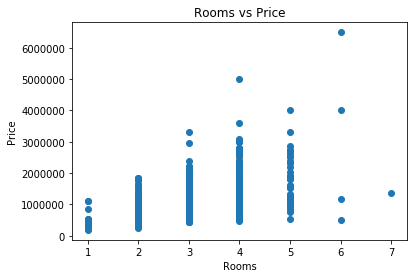

In [94]:
# Rooms vs Price
plt.scatter(dataLinearModel["Rooms"],dataLinearModel["Price"])
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Rooms vs Price')

We can see that the datapoints for `Rooms` column are discrete in nature. Therefore, this doesn't needs any transformation. We will transform other predictors to a similar scale as of Rooms. Hence, we leave Rooms as it is, no changes are required.

#### 3.2.2. crime_C_average

Text(0.5, 1.0, 'crime_C_average vs Price')

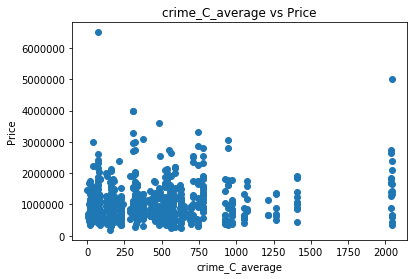

In [95]:
# crime_C_average vs Price
plt.scatter(dataLinearModel["crime_C_average"],dataLinearModel["Price"])
plt.xlabel('crime_C_average')
plt.ylabel('Price')
plt.title('crime_C_average vs Price')

(array([208., 148., 154.,  88.,  30.,  17.,  17.,   0.,   0.,  20.]),
 array([1.00000000e+00, 2.05133333e+02, 4.09266667e+02, 6.13400000e+02,
        8.17533333e+02, 1.02166667e+03, 1.22580000e+03, 1.42993333e+03,
        1.63406667e+03, 1.83820000e+03, 2.04233333e+03]),
 <a list of 10 Patch objects>)

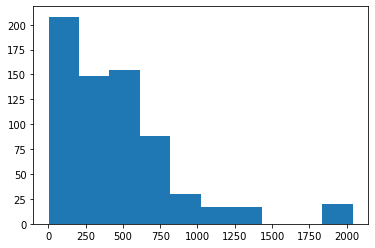

In [96]:
plt.hist(dataLinearModel['crime_C_average'])

The data looks right skewed. `Log transformations` are often recommended for skewed data. Log transforming data usually has the effect of spreading out clumps of data and bringing together spread-out data.

In [97]:
# creating a copy of the Linear Model that we created before
dataLinearModel = dataLinearModel.copy()

# adding a column which has the logarithmic values for 'crime_C_average' 
dataLinearModel['crime_C_average_logged'] = dataLinearModel['crime_C_average'].apply(math.log)

(array([  1.,   0.,   2.,  27.,  34.,  56.,  88., 158., 250.,  66.]),
 array([0.        , 0.76218482, 1.52436964, 2.28655447, 3.04873929,
        3.81092411, 4.57310893, 5.33529376, 6.09747858, 6.8596634 ,
        7.62184822]),
 <a list of 10 Patch objects>)

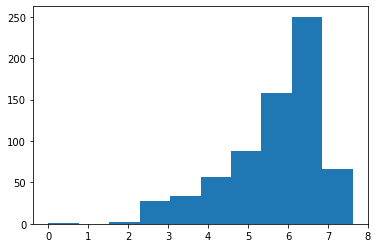

In [98]:
plt.hist(dataLinearModel['crime_C_average_logged'])

An added advantage of doing log transformation is that, it makes the transformed values interpretable. The log transformed values can be treated as the change in percentage off the true variable.

#### 3.2.3. travel_min_to_CBD

Text(0.5, 1.0, 'travel_min_to_CBD vs Price')

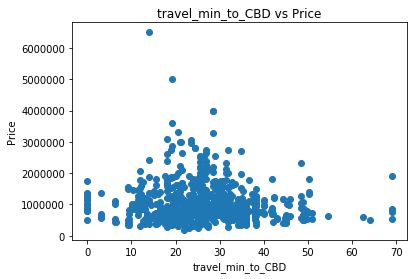

In [99]:
# travel_min_to_CBD vs Price
plt.scatter(dataLinearModel["travel_min_to_CBD"],dataLinearModel["Price"])
plt.xlabel('travel_min_to_CBD')
plt.ylabel('Price')
plt.title('travel_min_to_CBD vs Price')

(array([ 23.,  49., 125., 186., 158.,  82.,  28.,  25.,   0.,   6.]),
 array([ 0. ,  6.9, 13.8, 20.7, 27.6, 34.5, 41.4, 48.3, 55.2, 62.1, 69. ]),
 <a list of 10 Patch objects>)

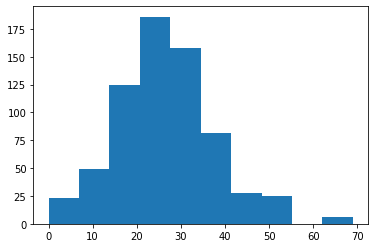

In [100]:
plt.hist(dataLinearModel['travel_min_to_CBD'])

Based on the above histogram plot, we can see that the plot looks fairly normal. Since, after transforming, other features/predictors are brought down to scale of 1 to 10, we would scale `travel_min_to_CBD` using the method of `min-max` transformation.

In [101]:
# creating a copy of the Linear Model that we created before
dataLinearModel = dataLinearModel.copy()

# Implementing min-max transformation
scaler = preprocessing.MinMaxScaler(feature_range=(1, 10))
dataLinearModel['travel_min_to_CBD_minmax'] = scaler.fit_transform(dataLinearModel[['travel_min_to_CBD']])

Text(0.5, 1.0, 'travel_min_to_CBD_minmax vs Price')

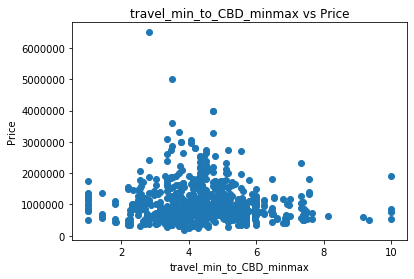

In [102]:
# travel_min_to_CBD vs Price
plt.scatter(dataLinearModel["travel_min_to_CBD_minmax"],dataLinearModel["Price"])
plt.xlabel('travel_min_to_CBD_minmax')
plt.ylabel('Price')
plt.title('travel_min_to_CBD_minmax vs Price')

(array([ 23.,  49., 125., 186., 158.,  82.,  28.,  25.,   0.,   6.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

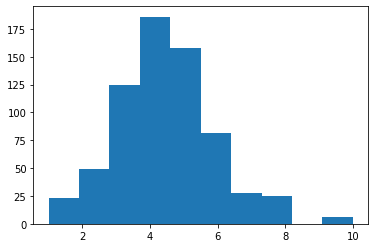

In [103]:
plt.hist(dataLinearModel['travel_min_to_CBD_minmax'])

As we see in the two figures above (scatter plot of `travel_min_to_CBD` and `travel_min_to_CBD_minmax`), the relation of travel time and price is still the same, but we have brought down the scale of it in sync with other predictors. This kind of scaling is especially useful in clustering techniques, where distance metrices are calculated, but they are useful to Linear Regression as well. 

(<matplotlib.axes._subplots.AxesSubplot at 0x1d5221b4f28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d5221b4f28>)

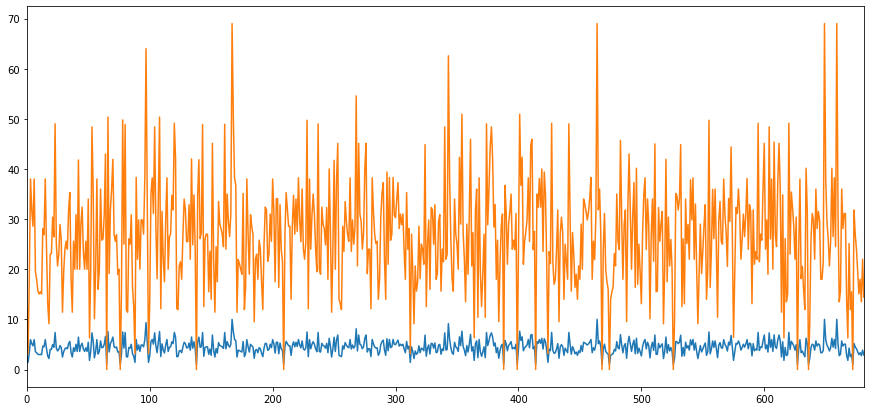

In [104]:
plt.figure(figsize=(15,7))
dataLinearModel["travel_min_to_CBD_minmax"].plot(), dataLinearModel["travel_min_to_CBD"].plot()

In the above graph we plot the original `travel_min_to_CBD` value along with the `travel_min_to_CBD_minmax` value which we get after performing `min-max` normalization on it. And we can see that `travel_min_to_CBD_minmax`is transformed into values between 0 and 10 as expected.  

#### 3.2.4. Age

Text(0.5, 1.0, 'Age vs Price')

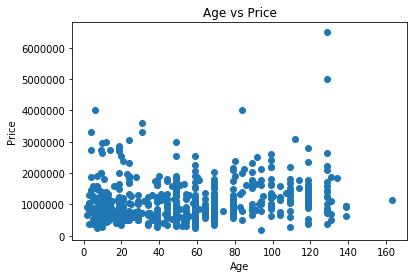

In [105]:
# Age vs Price
plt.scatter(dataLinearModel["Age"],dataLinearModel["Price"])
plt.xlabel('Age')
plt.ylabel('Price')
plt.title('Age vs Price')

(array([145.,  98., 138., 101.,  71.,  34.,  44.,  41.,   9.,   1.]),
 array([  2. ,  18.1,  34.2,  50.3,  66.4,  82.5,  98.6, 114.7, 130.8,
        146.9, 163. ]),
 <a list of 10 Patch objects>)

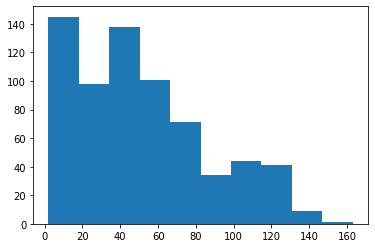

In [106]:
plt.hist(dataLinearModel['Age'])

We can normalize the above data by creating a new column which would have its respective root values for `Age`. We perform square root transformation on it, because we know that this is an example of counted data, and using this transformation we can hope that we will achieve a normal distribution and get rid of some of the skewness.

(array([ 34.,  87.,  75.,  48., 137., 101.,  80.,  66.,  49.,   5.]),
 array([ 1.41421356,  2.54950674,  3.68479992,  4.82009309,  5.95538627,
         7.09067945,  8.22597263,  9.3612658 , 10.49655898, 11.63185216,
        12.76714533]),
 <a list of 10 Patch objects>)

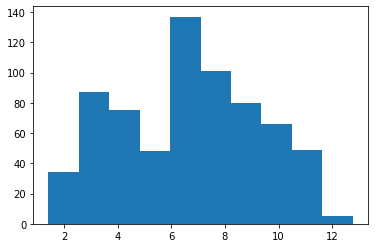

In [107]:
# creating a copy of the Linear Model that we created before
dataLinearModel = dataLinearModel.copy()

# adding a column which has the logarithmic values for 'Age' 
dataLinearModel['Age_root'] = dataLinearModel['Age'].apply(math.sqrt)

# Plotting histogram
plt.hist(dataLinearModel['Age_root'])

### 3.3. Calculating Regression Score for transformed features/predictors

In [108]:
# Create LinearRegression object 
lr = LinearRegression()

# Creating trianing and testing dataset (75-25 split)
dataXTrain, dataXTest, dataYTrain, dataYTest = train_test_split(dataLinearModel[['Rooms','Age_root','travel_min_to_CBD_minmax',
                                                                'crime_C_average_logged']], dataLinearModel[['Price']],
                                                                test_size=0.25, random_state=42)

# Fitting the training data onto the model
lr.fit(dataXTrain,dataYTrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [109]:
# Calculating the R score 
print('R squared value of the linear regression model: ', lr.score(dataXTrain,dataYTrain))

R squared value of the linear regression model:  0.37599630042223015


In [110]:
# Predicting the target value 
predictedPrice = lr.predict(dataXTest)

# Calculating the MSE and RMSE
print('MSE of the model: ', mean_squared_error(dataYTest, predictedPrice))
print('RMSE of the model: ', sqrt(mean_squared_error(dataYTest, predictedPrice)))

MSE of the model:  177339994101.71637
RMSE of the model:  421117.5537800774


So far, we have applied the following normalisation and transformations:

1) Min-Max Normalisation on travel_min_to_CBD.

2) Square Root Transformation on Age.

3) Log Transformation on crime_C_average.

Upon doing above operations, we see that the overall R-squared value of the model has reduced by 2% but RMSE value has decreased by about 1,115 units.

Now let's try transforming the target value and see its effect on accuracy and error.

### 3.4. Price

(array([291., 259.,  90.,  24.,  13.,   1.,   2.,   1.,   0.,   1.]),
 array([ 185000.,  816500., 1448000., 2079500., 2711000., 3342500.,
        3974000., 4605500., 5237000., 5868500., 6500000.]),
 <a list of 10 Patch objects>)

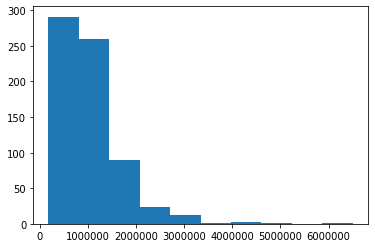

In [111]:
plt.hist(dataLinearModel['Price'])

We can see from above graph that the prices are not normally distributed. Since it is right skewed, we will apply `log transformation` similar to that of the crime data points.

(array([  3.,  26.,  68., 148., 195., 131.,  77.,  27.,   5.,   2.]),
 array([12.1281111 , 12.48403127, 12.83995143, 13.19587159, 13.55179176,
        13.90771192, 14.26363208, 14.61955225, 14.97547241, 15.33139257,
        15.68731273]),
 <a list of 10 Patch objects>)

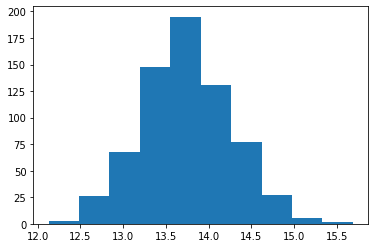

In [112]:
# creating a copy of the Linear Model that we created before
dataLinearModel = dataLinearModel.copy()

# adding a column which has the logarithmic values for 'crime_C_average' 
dataLinearModel['Price_logged'] = dataLinearModel['Price'].apply(math.log)

# Plotting histogram
plt.hist(dataLinearModel['Price_logged'])

One thing to note here is, the predictions when made, need to be back transformed to the original scale. This has been done below and when we compute MSE and RMSE, we see a significant improvement in them compared to previous models.

### 3.5. Calculating Regression Score with transformed target value

In [113]:
# Create LinearRegression object 
lr = LinearRegression()

# Creating trianing and testing dataset (75-25 split)
dataXTrain, dataXTest, dataYTrain, dataYTest = train_test_split(dataLinearModel[['Rooms','Age_root','travel_min_to_CBD_minmax',
                                                                'crime_C_average_logged']], dataLinearModel[['Price_logged']],
                                                                test_size=0.25, random_state=42)

# Fitting the training data onto the model
lr.fit(dataXTrain,dataYTrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [114]:
# Calculating the R score 
print('R squared value of the linear regression model: ', lr.score(dataXTrain,dataYTrain))

R squared value of the linear regression model:  0.41548647754470447


In [115]:
# Predicting the target value 
predictedPrice = lr.predict(dataXTest)

# Back Transformation 
predictedPrice = np.exp(predictedPrice)
dataYTest = np.exp(dataYTest)

# Calculating the MSE and RMSE
print('MSE of the model: ', mean_squared_error(dataYTest, predictedPrice))
print('RMSE of the model: ', sqrt(mean_squared_error(dataYTest, predictedPrice)))

MSE of the model:  165832902087.3287
RMSE of the model:  407225.86127028905


## 4. Conclusion

The necessary output file has been generated with the specified fields. 

* The transformations are done and it has been shown that these do help the Linear Regression model (in terms of MSE and RMSE).
* It helped the model even more, when the target value was also normalised.


## 5. References

- Monash lecture and tutorial files

- https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html

- http://www.biostathandbook.com/transformation.html#targetText=For%20the%20log%20transformation%2C%20you,be%20101.044%3D11.1%20fish.

- http://fmwww.bc.edu/repec/bocode/t/transint.html

- https://stackoverflow.com/questions/41436354/extract-data-from-static-html-file-using-python-3-5

- https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

- https://stackoverflow.com/questions/53645882/pandas-merging-101

- https://stackoverflow.com/questions/13703720/converting-between-datetime-timestamp-and-datetime64

- https://stats.stackexchange.com/questions/35591/normalization-vs-scaling

- https://datascience.stackexchange.com/questions/22957/am-i-doing-a-log-transformation-of-data-correctly

- http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html